In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())
import numpy as np

In [0]:
!git clone https://github.com/michalovsky/books-data.git

In [0]:
import glob

def read_data(directory):
  file_paths = glob.glob(directory +"*.txt")    
  text = ""
  for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
      file_content = file.read()
      text+=file_content
  return text

directory1 = "books-data/kafka/"
directory2 = "books-data/shelley/"
directory3 = "books-data/defoe/"
directory4 = "books-data/plato/"

text = read_data(directory1)
print ('Length of text: {} characters'.format(len(text)))

In [0]:
import string

class DataProcessor:
	def __init__(self, chars_to_remove, chars_to_translate, replacement_chars):
		self.chars_to_remove = chars_to_remove
		self.chars_to_translate = chars_to_translate
		self.replacement_chars = replacement_chars

	def preprocess_data(self, text):
		removal_translator = str.maketrans("", "", self.chars_to_remove)
		special_characters_translator = str.maketrans(self.chars_to_translate, self.replacement_chars , '')
		text = text.lower().translate(removal_translator).translate(special_characters_translator)
		text = " ".join(text.split())
		return text

characters_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits  
characters_to_translate = 'ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï'
replacement_characters = 'acelnoszzaoueeeeoaaaeceinouuuaei'

dataprocessor = DataProcessor(characters_to_remove, characters_to_translate, replacement_characters)
text = dataprocessor.preprocess_data(text)

vocab = sorted(list(set(text)))
print ('{} unique characters:'.format(len(vocab)))
print(vocab)
vocab_size = len(vocab)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from random import randint

char_to_indices = dict((c, i) for i, c in enumerate(vocab))
indices_to_char = dict((i, c) for i, c in enumerate(vocab))

class Dataset:
  def __init__(self):
    self.text_sequences = list()
    self.X_train = list()
    self.y_train = list()
    self.X_val = list()
    self.y_val = list()

  def make_dataset(self, text, sequence_length=40):
    sequences = list()
    labels = list()
    encoded_chars = np.array([char_to_indices[ch] for ch in text]) 
    for i in range(0, len(encoded_chars) - sequence_length, 1):
        sequences.append(encoded_chars[i:i + sequence_length])
        self.text_sequences.append(text[i:i + sequence_length])
        labels.append(encoded_chars[i + sequence_length])
    X = np.reshape(sequences, (len(sequences), sequence_length, 1))
    X = np_utils.to_categorical(X)
    y = np_utils.to_categorical(labels)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
    return self

  def get_random_sequence(self):
	  return self.text_sequences[randint(0, len(self.text_sequences))]

input_sequence_length = 40
dataset = Dataset().make_dataset(text, input_sequence_length)

Using TensorFlow backend.


[17 16  7  0 15 17 20 16 11 16  9  1  0 25 10  7 16  0  9 20  7  9 17 20
  0 21  3 15 21  3  0 25 17 13  7  0  8 20 17 15]
one morning, when gregor samsa woke from


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.constraints import max_norm

class Model:
  def __init__(self):
    self.model = Sequential()
    self.__build_model()
    self.__compile_model()
    self.model.summary()

  def __build_model(self):
    self.model.add(LSTM(90, input_shape=(input_sequence_length, vocab_size),return_sequences=True, recurrent_initializer='glorot_uniform'))
    self.model.add(LSTM(90, recurrent_initializer='glorot_uniform'))
    self.model.add(Dense(vocab_size, activation='softmax'))

  def __compile_model(self):
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def fit_model(self, X_train, y_train, validation_data, epochs, batch_size, callbacks):
    return self.model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks
    )

model = Model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40, 90)            43200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 90)                65160     
_________________________________________________________________
dense_2 (Dense)              (None, 29)                2639      
Total params: 110,999
Trainable params: 110,999
Non-trainable params: 0
_________________________________________________________________


In [0]:
import sys

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(model, seed, characters_amount=100):
    print('Generating with seed: "' + seed + '"')
    
    sentence = seed
    generated = ''
    generated += sentence
    sys.stdout.write(generated)

    for i in range(characters_amount):
        x_pred = np.zeros((1, input_sequence_length, vocab_size))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_to_indices[char]] = 1.
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = indices_to_char[next_index]
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        if next_char=='.':
          sys.stdout.write("\n")
        sys.stdout.flush()
    print()


In [0]:
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

seed_for_epochs = dataset.get_random_sequence()
print("Checking with seed:", seed_for_epochs)

def on_epoch_end(epoch, _):
    print()
    generate_text(model.model, seed=seed_for_epochs, characters_amount=100)
    print()

text_generation = LambdaCallback(on_epoch_end=on_epoch_end)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=40)

Checking with seed: aken it will do him no harm but the man 


In [0]:
batch_size = 100
epochs = 80
callbacks = [early_stopping, text_generation]
history = model.fit_model(dataset.X_train, dataset.y_train, validation_data=(dataset.X_val, dataset.y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 447012 samples, validate on 111754 samples
Epoch 1/80

Generating with seed: "aken it will do him no harm but the man "
aken it will do him no harm but the man simpen as out uf that have go nit not as fay penialy biked a cany uatr.
 but k himsalle that staided 

447012/447012 - 52s - loss: 2.0213 - accuracy: 0.4065 - val_loss: 1.7237 - val_accuracy: 0.4809
Epoch 2/80

Generating with seed: "aken it will do him no harm but the man "
aken it will do him no harm but the man of cout ruaten.
 k draad to see still, is that if from but congectuped dont dost the buch be and if s

447012/447012 - 48s - loss: 1.6136 - accuracy: 0.5120 - val_loss: 1.5288 - val_accuracy: 0.5338
Epoch 3/80

Generating with seed: "aken it will do him no harm but the man "
aken it will do him no harm but the man afpeareffle, you that, what it, and poseinital, indiscisiately had been.
 say we looded.
 youre dowing

447012/447012 - 48s - loss: 1.4635 - accuracy: 0.5523 - val_loss: 1.4192 - val_accuracy: 0.5654

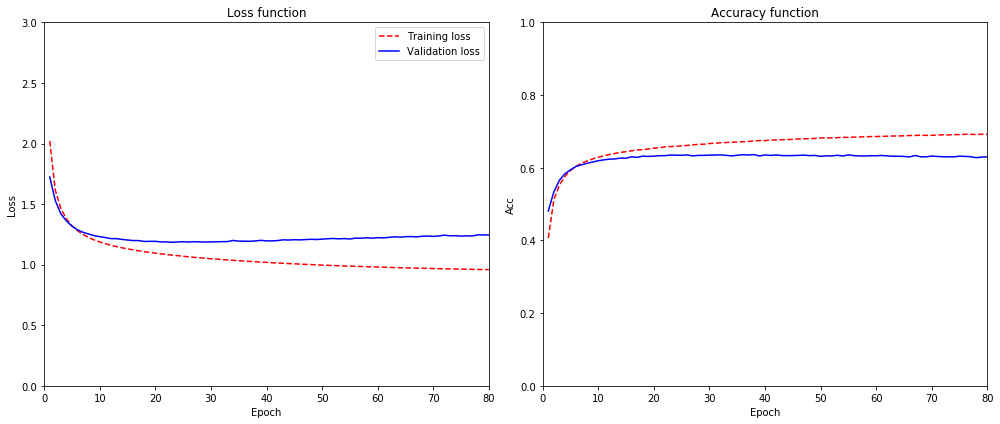

In [0]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [0]:
seed = dataset.get_random_sequence()
print("Generating with seed:", seed, "\n")
generate_text(model.model, seed, characters_amount=1000)

Generating with seed: k at the altar picture by the light of h 

Generating with seed: "k at the altar picture by the light of h"
k at the altar picture by the light of her skirts and insult or even the pressed left the man ones ingot the door early to catcled me this show under it, although theyre there in fact of this time when gregors mother, that the conversation at the door and it had to see time he went over to the bank also ling his hand to make it levelch obne and said.
 when k was more than an apparent acquittal, have the little state, suttoas of turning to the bedside to see it said everything earne yourself, began understood, when this is it you dont think of this questions his parents even becoming enough very difficult, said the while sconorracher and would have probably carefully of this to let anyone want to do with them it was especially but for very complets about my progress, as far as they sat the peace bittened in front of him, struck to sharp, walking over the room